Uncomment and run this code if Google Drive is not mounted to Colab


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [1]:
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
from keras import layers, Model
import PIL
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import pathlib
from tensorflow.python.client import device_lib
import zipfile
import pandas as pd
import glob
from collections import Counter
from tensorflow.keras.applications import DenseNet121
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.densenet import preprocess_input
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report

### To access the dataset from kaggle in Colab
1. Go to your account, Scroll to API section and Click **Expire API Token** to remove previous tokens

2. Click on **Create New API Token** - It will download kaggle.json file on your machine.

3. Go to your Google Colab project file and run the following commands:

4. **! pip install -q kaggle**

5. **from google.colab import files**

**files.upload()**

* Choose the kaggle.json file that you downloaded
6. **! mkdir ~/.kaggle**

**! cp kaggle.json ~/.kaggle/**

* Make directory named kaggle and copy kaggle.json file there.
7. **! chmod 600 ~/.kaggle/kaggle.json**

* Change the permissions of the file.

In [ ]:
# !pip install -q kaggle
# from google.colab import files
# !mkdir ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

In [2]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/kaggle" 

# Downloading the dataset from Kaggle

In [3]:
!kaggle datasets download kmader/skin-cancer-mnist-ham10000

100% 5.20G/5.20G [01:45<00:00, 36.5MB/s]
100% 5.20G/5.20G [01:45<00:00, 52.8MB/s]


In [4]:
!mkdir ham10k

# Unzipping the dataset

In [5]:
zip_path = '/content/skin-cancer-mnist-ham10000.zip'
base_dir = '/content/ham10k'

zip_ref = zipfile.ZipFile(zip_path, 'r')
zip_ref.extractall(base_dir)
zip_ref.close()

# Previewing the metadata file

In [6]:
meta_dir = os.path.join(base_dir, 'HAM10000_metadata.csv')
metadata = pd.read_csv(meta_dir)
metadata

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face


In [7]:
# Readable versions of classification labels
class_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

Adding the filepath of the image to the metadata file

In [8]:
img_dir_1 = os.path.join(base_dir, 'HAM10000_images_part_1')
img_dir_2 = os.path.join(base_dir, 'HAM10000_images_part_2')

img_part_1 = os.listdir(img_dir_1)
img_part_2 = os.listdir(img_dir_2)

In [9]:
def img_path(x):
    
    file = x + '.jpg'
    
    if file in img_part_1:
        
        return os.path.join(img_dir_1, file)
    
    elif file in img_part_2:
        
        return os.path.join(img_dir_2, file)

In [10]:
metadata['image'] = metadata['image_id'].apply(img_path)

In [11]:
metadata.sample(10)

,lesion_id,image_id,dx,dx_type,age,sex,localization,image
8186,HAM_0006363,ISIC_0024936,nv,histo,25.0,male,abdomen,/content/ham10k/HAM10000_images_part_1/ISIC_00...
8133,HAM_0000139,ISIC_0027909,nv,histo,45.0,female,chest,/content/ham10k/HAM10000_images_part_1/ISIC_00...
8476,HAM_0001656,ISIC_0026759,nv,histo,70.0,female,lower extremity,/content/ham10k/HAM10000_images_part_1/ISIC_00...
6758,HAM_0006738,ISIC_0029374,nv,histo,55.0,male,foot,/content/ham10k/HAM10000_images_part_2/ISIC_00...
2813,HAM_0004514,ISIC_0030690,bcc,histo,50.0,female,back,/content/ham10k/HAM10000_images_part_2/ISIC_00...
1649,HAM_0005748,ISIC_0034065,mel,histo,50.0,male,trunk,/content/ham10k/HAM10000_images_part_2/ISIC_00...
884,HAM_0001678,ISIC_0027831,bkl,consensus,60.0,male,face,/content/ham10k/HAM10000_images_part_1/ISIC_00...
9186,HAM_0005008,ISIC_0030919,nv,histo,60.0,male,lower extremity,/content/ham10k/HAM10000_images_part_2/ISIC_00...
3607,HAM_0000227,ISIC_0032201,nv,follow_up,45.0,male,lower extremity,/content/ham10k/HAM10000_images_part_2/ISIC_00...
6119,HAM_0002001,ISIC_0030595,nv,follow_up,40.0,male,lower extremity,/content/ham10k/HAM10000_images_part_2/ISIC_00...


Verifying that `image_id` and `image` are correctly paired in the dataframe

In [ ]:
print(metadata.iloc[3778]['image_id'] + "-------" + metadata.iloc[3778]['image'])

ISIC_0030092-------/content/ham10k/HAM10000_images_part_2/ISIC_0030092.jpg


# Previewing Image Data

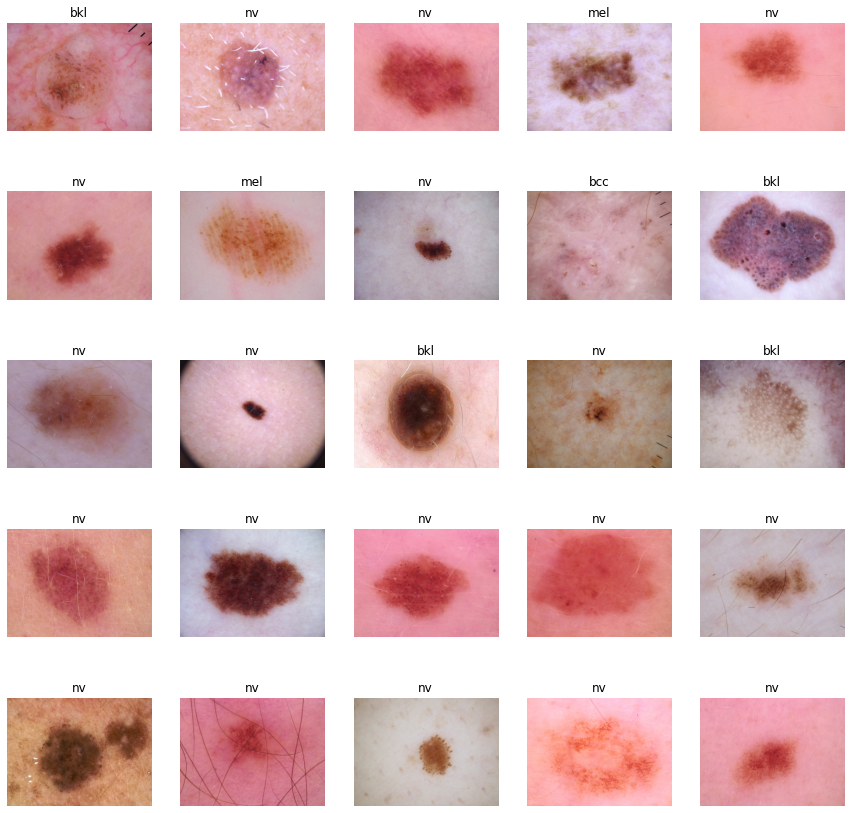

In [ ]:
sample_imgs = metadata.sample(25)


plt.figure(figsize=(15,15))
for i in range(25):
  ax = plt.subplot(5,5, i + 1)
  image =  mpimg.imread(sample_imgs.iloc[i]['image']) 
  plt.imshow(image)
  plt.title(sample_imgs.iloc[i]['dx'])
  plt.axis("off")

# Visualizing the distribution of labels

In [ ]:
class_count = Counter(metadata['dx'])
class_count_list = []
[class_count_list.append(x) for x in class_count.values()]
class_count_list

[1099, 6705, 115, 1113, 142, 514, 327]

<BarContainer object of 7 artists>

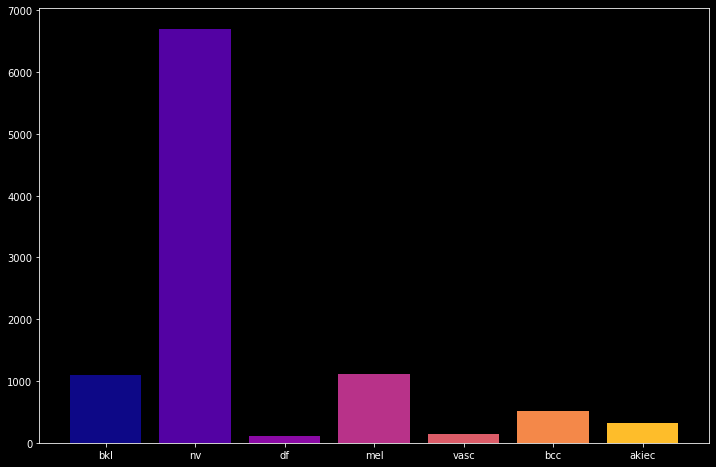

In [ ]:
plt.style.use('dark_background')
my_cmap = plt.get_cmap("plasma")
x = np.arange(7).astype(float)
plt.figure(figsize = (12,8))
plt.bar(class_count.keys(), 
        height=class_count_list, 
        color=my_cmap(x/7))

There is a large imbalance in the dataset favored towards `nv`. Once the dataset is split into train/val/test, the imbalance can be addressed through the training set.

# Train/Val/Test Split

Splitting the data into train/val/test = 85/10/5

In [12]:
# 85% for the train set, the remaining 15% will be split for val and test
train_df, val_test = train_test_split(metadata, test_size=0.15, random_state=54)
val_df, test_df = train_test_split(val_test, test_size=0.33, random_state=54)


In [ ]:
print(f'Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}')

Train: 8512 | Val: 1007 | Test: 496


In [15]:
BATCH_SIZE = 64

# Preprocess for densenet

ImageDataGenerator will augment the images to generate pseudo-new data. By altering the array representation of an image slightly (shifting to one size or rotating), this helps prevent the model from overfitting.

In [13]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    shear_range = 0.2,
    rotation_range = 30,
    zoom_range = 0.2,
    horizontal_flip = True,
    vertical_flip = True,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    # preprocess_input returns img data rescaled from 0-1 and each channel 
    # is normalized with respect to ImageNet dataset
    preprocessing_function=preprocess_input
)

In [16]:
train_data = train_datagen.flow_from_dataframe (
    train_df,
    x_col = 'image',
    y_col = 'dx',
    shuffle = True,
    seed = 930,
    batch_size = BATCH_SIZE,
    class_mode = 'categorical'
)

Found 8512 validated image filenames belonging to 7 classes.


In [17]:
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=preprocess_input
)

In [18]:
val_data = val_datagen.flow_from_dataframe(
    val_df,
    x_col = 'image',
    y_col = 'dx',
    shuffle = True,
    seed =930,
    # target_size = TARGET_SIZE,
    batch_size = BATCH_SIZE,
    class_mode = 'categorical'
)

Found 1007 validated image filenames belonging to 7 classes.


In [19]:
class_count = Counter(train_data.classes)
class_count_list = []
for i in range(7):
  class_count_list.append(class_count[i])
# [class_count_list.append(x) for x in class_count.values()]
class_count_list

[285, 438, 937, 98, 967, 5670, 117]

These are the indices of the classes within the `ImageDataGenerator`

In [20]:
train_data.class_indices

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}

<BarContainer object of 7 artists>

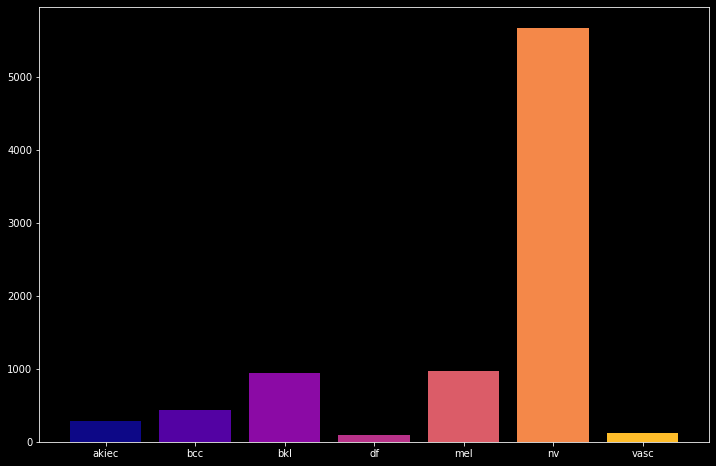

In [ ]:
plt.style.use('dark_background')
my_cmap = plt.get_cmap("plasma")
x = np.arange(7).astype(float)
plt.figure(figsize = (12,8))
plt.bar(train_data.class_indices.keys(), 
        height=class_count_list, 
        color=my_cmap(x/7))

# Applying weights 
Weights are applied to the classes so the model is rewarded more for classifying minority classes correctly and punished more heavily for incorrectly misclassifying minority classes.

In [21]:
train_img_num = train_data.n

In [22]:
class_weight = {}

for i in range(7):
  weight_name = "weight_for_" + str(i)
  weight_var = (1 / class_count_list[i])*(train_img_num)/7.0 
  class_weight.update({i: weight_var})
  print('{}: {:.2f}'.format(weight_name, weight_var))

weight_for_0: 4.27
weight_for_1: 2.78
weight_for_2: 1.30
weight_for_3: 12.41
weight_for_4: 1.26
weight_for_5: 0.21
weight_for_6: 10.39


The classes with the fewest number of examples in the training set have the highest values for their weights

# Running image data on DenseNet121

In [23]:
def plot_model_acc(history):
  plt.figure(figsize=(15,15))
  plt.subplot(2,1,1)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.subplot(2,1,2)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper right')
  plt.show()

In [ ]:

conv_base = DenseNet121(weights='imagenet',
                     include_top=False,
                     input_shape = (224, 224, 3))

conv_base.trainable = False

topClassifier = conv_base.output

topClassifier = layers.GlobalAveragePooling2D()(topClassifier)

topClassifier = layers.Dense(7, activation="softmax")(topClassifier)

model = Model(inputs=conv_base.input, outputs=topClassifier)

In [ ]:
BATCH_SIZE = 64

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=1000,
    decay_rate=0.9)

opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(loss="categorical_crossentropy", metrics=['accuracy'], optimizer=opt)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, min_delta=1e-3, restore_best_weights=True)



history = model.fit(
            train_data,
            validation_data = val_data,
            batch_size = BATCH_SIZE,
            epochs = 50,
            class_weight = class_weight,
            callbacks=early_stop )

Epoch 1/50
266/266 [==============================] - 203s 746ms/step - loss: 2.0273 - accuracy: 0.2842 - val_loss: 1.2510 - val_accuracy: 0.5482
Epoch 2/50
266/266 [==============================] - 198s 745ms/step - loss: 1.3865 - accuracy: 0.5374 - val_loss: 1.1714 - val_accuracy: 0.5809
Epoch 3/50
266/266 [==============================] - 198s 746ms/step - loss: 1.1995 - accuracy: 0.5874 - val_loss: 1.2079 - val_accuracy: 0.5660
Epoch 4/50
266/266 [==============================] - 199s 748ms/step - loss: 1.1632 - accuracy: 0.5918 - val_loss: 1.1989 - val_accuracy: 0.5343
Epoch 5/50
266/266 [==============================] - 196s 736ms/step - loss: 1.0712 - accuracy: 0.6245 - val_loss: 1.1897 - val_accuracy: 0.5531
Epoch 6/50
266/266 [==============================] - 192s 721ms/step - loss: 1.0516 - accuracy: 0.6383 - val_loss: 1.1580 - val_accuracy: 0.5720
Epoch 7/50
266/266 [==============================] - 193s 727ms/step - loss: 1.0348 - accuracy: 0.6201 - val_loss: 1.1489 -

In [ ]:
drive_dir = os.path.join(os.getcwd(), 'drive', 'MyDrive', 'ham10k', "skin_lesion_densenet_base.h5")
model.save(drive_dir, overwrite=True)

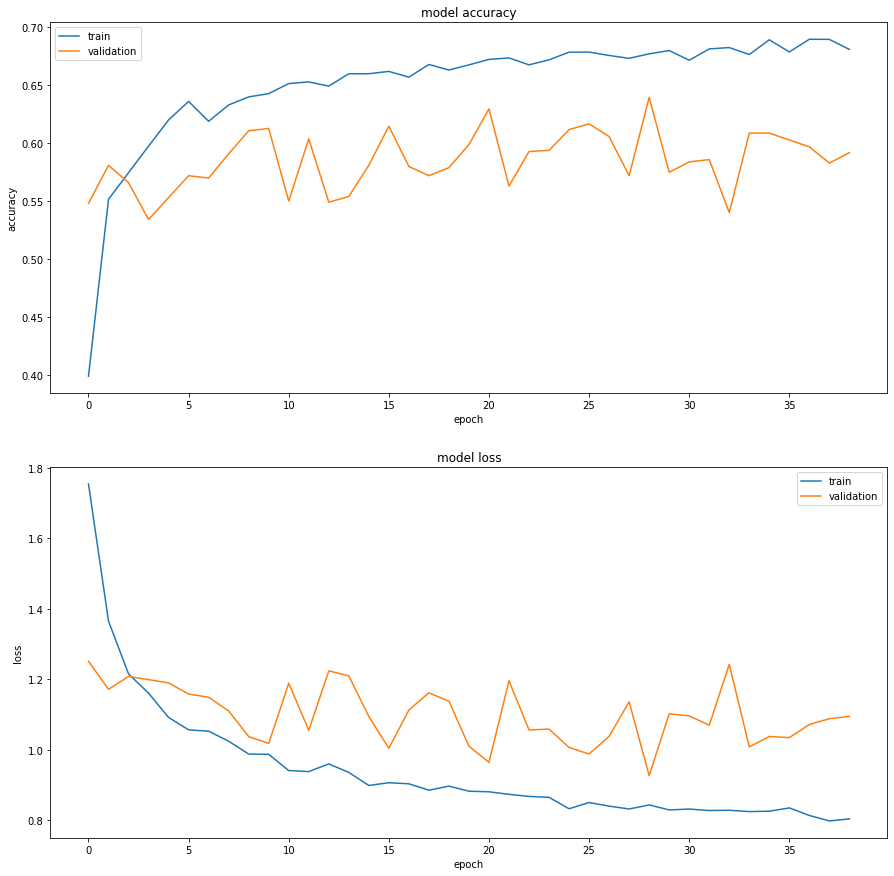

In [ ]:
 plot_model_acc(history)

### Unfreezing the base to fine tune

In [ ]:
base_model_dir = os.path.join(os.getcwd(), 'drive', 'MyDrive', 'ham10k', "skin_lesion_densenet_base.h5")
model = tf.keras.models.load_model(base_model_dir)

In [ ]:
model.trainable = True

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-5)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, min_delta=1e-3, restore_best_weights=True)


model.compile(loss="categorical_crossentropy", metrics=['accuracy'], optimizer=opt)

history = model.fit(
            train_data,
            validation_data = val_data,
            epochs = 150,
            callbacks=callback,
            class_weight = class_weight,
            batch_size = BATCH_SIZE,
            verbose = 1)

Epoch 1/150
266/266 [==============================] - 205s 736ms/step - loss: 1.6507 - accuracy: 0.5342 - val_loss: 1.2701 - val_accuracy: 0.5402
Epoch 2/150
266/266 [==============================] - 193s 724ms/step - loss: 0.9736 - accuracy: 0.6031 - val_loss: 1.2388 - val_accuracy: 0.5551
Epoch 3/150
266/266 [==============================] - 193s 724ms/step - loss: 0.8439 - accuracy: 0.6415 - val_loss: 1.0959 - val_accuracy: 0.6187
Epoch 4/150
266/266 [==============================] - 192s 723ms/step - loss: 0.7234 - accuracy: 0.6858 - val_loss: 1.0276 - val_accuracy: 0.6326
Epoch 5/150
266/266 [==============================] - 192s 723ms/step - loss: 0.6928 - accuracy: 0.6936 - val_loss: 1.0222 - val_accuracy: 0.6495
Epoch 6/150
266/266 [==============================] - 192s 723ms/step - loss: 0.6166 - accuracy: 0.7162 - val_loss: 1.0538 - val_accuracy: 0.6326
Epoch 7/150
266/266 [==============================] - 194s 728ms/step - loss: 0.5472 - accuracy: 0.7216 - val_loss: 0

In [ ]:
drive_dir = os.path.join(os.getcwd(), 'drive', 'MyDrive', 'ham10k', "skin_lesion_densenet_tuned.h5")
model.save(drive_dir, overwrite=True)

We can see that the model overfits the training set.

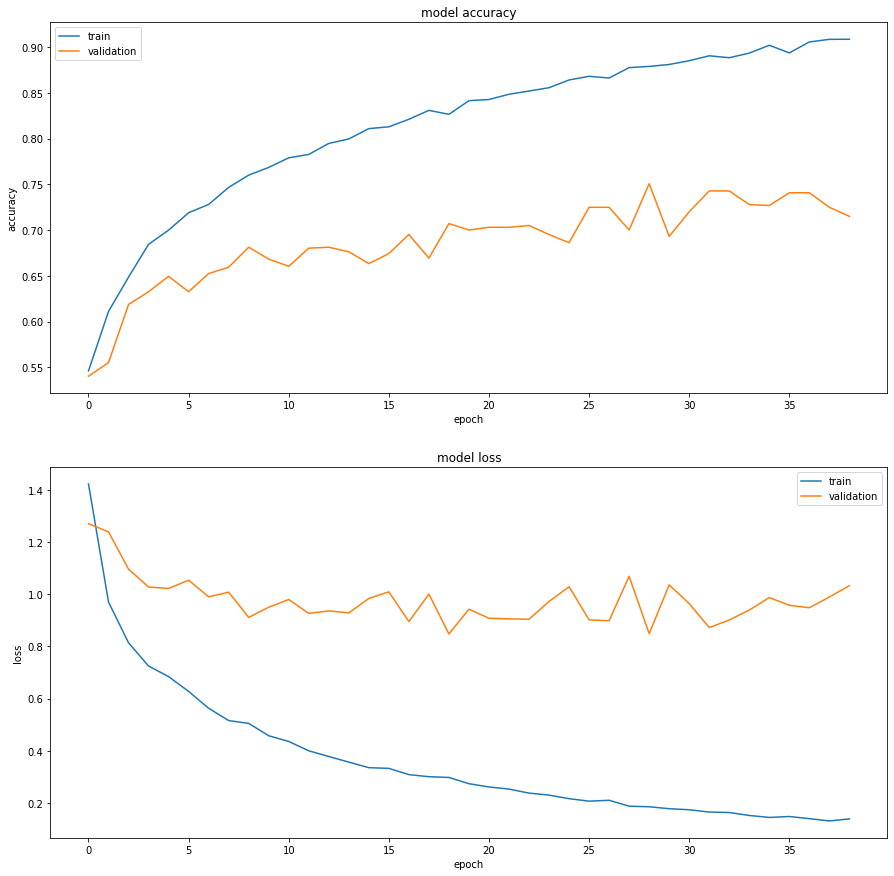

In [ ]:
 plot_model_acc(history)

In [ ]:
model_dir = os.path.join(os.getcwd(), 'drive', 'MyDrive', 'ham10k', "skin_lesion_densenet_tuned.h5")

model = tf.keras.models.load_model(model_dir)

In [ ]:
model.evaluate(val_data)

32/32 [==============================] - 28s 311ms/step - loss: 0.8489 - accuracy: 0.7507


[0.8489037752151489, 0.7507447600364685]

In [ ]:
m_dir = os.path.join(os.getcwd(), 'drive', 'MyDrive', 'ham10k', "skin_lesion_densenet_tuned.h5")
model = tf.keras.models.load_model(m_dir)

In [ ]:
y_pred = model.predict(val_data)

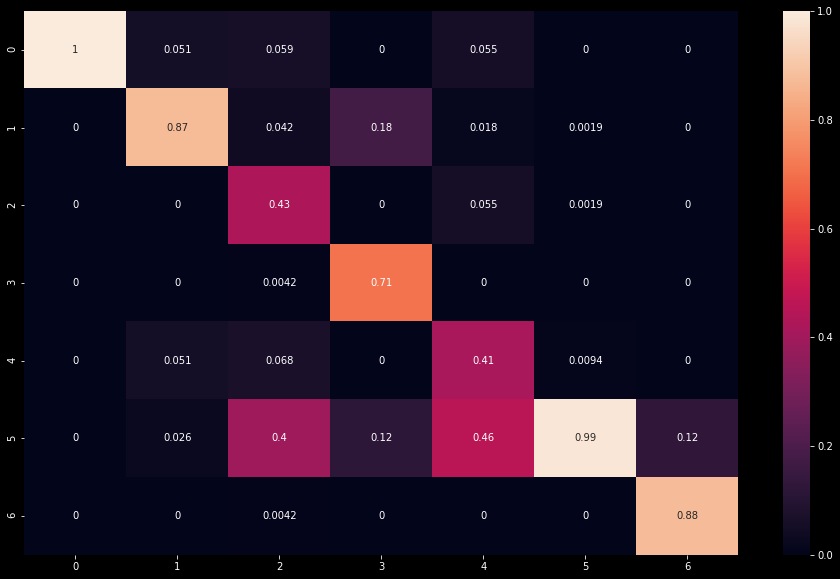

In [ ]:
predicted_labels = np.argmax(y_pred, axis=1)

true_labels = val_data.classes   

cm = confusion_matrix(true_labels, predicted_labels, normalize='pred') #normalized over the true label
plt.figure(figsize=(16,10))
f = sns.heatmap(cm, annot=True)

# Customizing the Hyperparameter tuning process with Frozen weights

Defining a model builder function to use for a hyperparameter tuning loop

In [ ]:
def build_model(b_size, l_rate):
  conv_base = DenseNet121(weights='imagenet',
                    include_top=False,
                    input_shape = (224, 224, 3))

  conv_base.trainable = False

  topClassifier = conv_base.output

  topClassifier = layers.GlobalAveragePooling2D()(topClassifier)

  topClassifier = layers.Dense(7, activation="softmax")(topClassifier)

  model = Model(inputs=conv_base.input, outputs=topClassifier)

  BATCH_SIZE = b_size

  lr_schedule = keras.optimizers.schedules.ExponentialDecay(
      initial_learning_rate= l_rate,
      decay_steps=1000,
      decay_rate=0.9)

  opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
  model.compile(loss="categorical_crossentropy", metrics=['accuracy'], optimizer=opt)

  early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, min_delta=1e-3, restore_best_weights=True)



  history = model.fit(
              train_data,
              validation_data = val_data,
              batch_size = b_size,
              epochs = 15,
              class_weight = class_weight,
              callbacks=early_stop )

Since the hyperparameter space is small, we can use a grid search to tune learning rate and batch size. (Note: this process can take 7+ hours to complete)

In [ ]:
def tune_hypers():
  performance = {}
  lr = [3e-3, 1e-3, 3e-4]
  batch_size = [32, 64, 96]

  for rate in lr:
    for b_sz in batch_size:
      build_model(b_sz, rate)
      # The call to save the model was in the wrong scope when executed here so I've commented it out.
      # This should have been inside the build_model() function 
      #drive_dir = os.path.join(os.getcwd(), 'drive', 'MyDrive', 'ham10k', f"tune_hypers_{str(rate)}_{str(b_sz)}.h5")
      #model.save(drive_dir)
      x = model.evaluate(val_data)
      performance[f"{b_sz}/{lr}"] = x[1]



In [ ]:
tune_hypers()

Epoch 1/15
133/133 [==============================] - 203s 1s/step - loss: 1.9649 - accuracy: 0.3413 - val_loss: 1.0211 - val_accuracy: 0.6465
Epoch 2/15
133/133 [==============================] - 209s 2s/step - loss: 1.2555 - accuracy: 0.5637 - val_loss: 1.2965 - val_accuracy: 0.5124
Epoch 3/15
133/133 [==============================] - 197s 1s/step - loss: 1.2201 - accuracy: 0.5636 - val_loss: 1.0350 - val_accuracy: 0.6197
Epoch 4/15
133/133 [==============================] - 193s 1s/step - loss: 1.0821 - accuracy: 0.6247 - val_loss: 1.1963 - val_accuracy: 0.5690
Epoch 5/15
133/133 [==============================] - 192s 1s/step - loss: 1.1368 - accuracy: 0.5967 - val_loss: 0.9638 - val_accuracy: 0.6445
Epoch 6/15
133/133 [==============================] - 191s 1s/step - loss: 1.0124 - accuracy: 0.6275 - val_loss: 1.0979 - val_accuracy: 0.5829
Epoch 7/15
133/133 [==============================] - 192s 1s/step - loss: 0.9380 - accuracy: 0.6348 - val_loss: 0.8544 - val_accuracy: 0.6902

An error in the code caused the wrong model to be saved for each loop. That being said, the first iteration yielded the highest validation accuracy at 0.6902 in epoch 7. The next best validation accuracy was in iteration 4 in epoch 9 with .67.

* **1st iteration**: learning rate: **.003**, batch size: **32**
* **4th iteration**: learning rate: **.001**, batch size: **32**

# Freezing weights and using hyperparameter tuning results

Epoch 1/100
133/133 [==============================] - 201s 1s/step - loss: 1.8932 - accuracy: 0.3116 - val_loss: 1.3140 - val_accuracy: 0.4916
Epoch 2/100
133/133 [==============================] - 193s 1s/step - loss: 1.3195 - accuracy: 0.5777 - val_loss: 1.0932 - val_accuracy: 0.5899
Epoch 3/100
133/133 [==============================] - 194s 1s/step - loss: 1.1383 - accuracy: 0.5976 - val_loss: 0.9562 - val_accuracy: 0.6316
Epoch 4/100
133/133 [==============================] - 193s 1s/step - loss: 1.0783 - accuracy: 0.6194 - val_loss: 1.1570 - val_accuracy: 0.5809
Epoch 5/100
133/133 [==============================] - 194s 1s/step - loss: 1.0590 - accuracy: 0.6154 - val_loss: 1.3095 - val_accuracy: 0.5074
Epoch 6/100
133/133 [==============================] - 195s 1s/step - loss: 1.0548 - accuracy: 0.6275 - val_loss: 1.1631 - val_accuracy: 0.5670
Epoch 7/100
133/133 [==============================] - 201s 2s/step - loss: 0.9784 - accuracy: 0.6416 - val_loss: 1.1511 - val_accuracy:

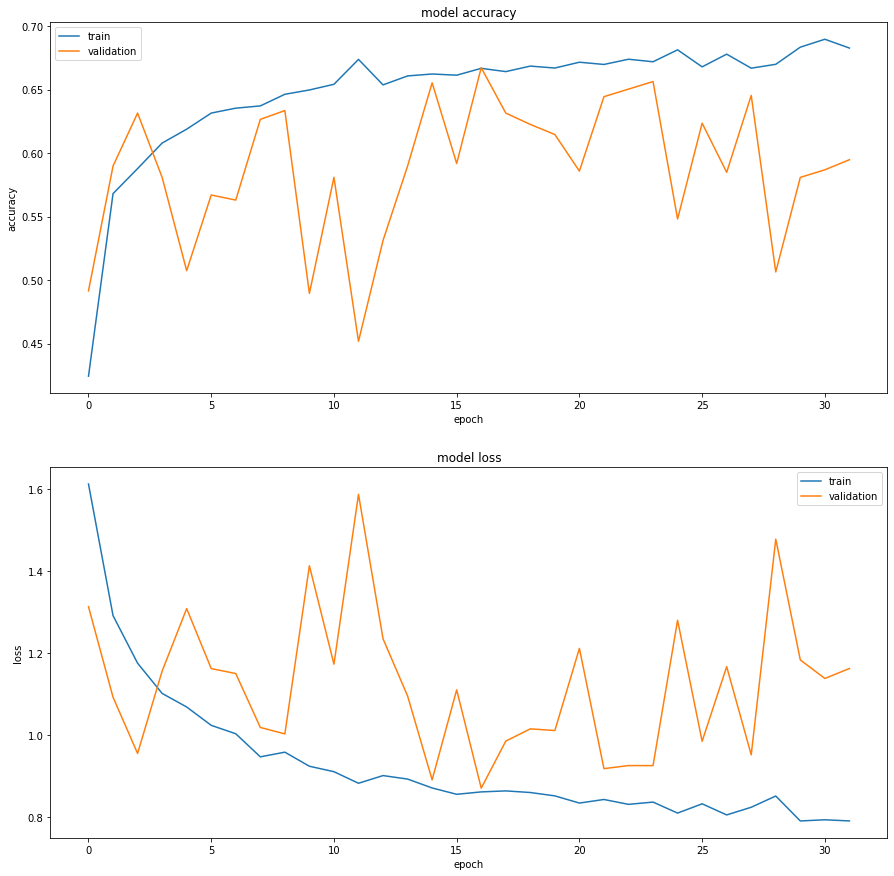

In [ ]:
conv_base = DenseNet121(weights='imagenet',
                  include_top=False,
                  input_shape = (224, 224, 3))

conv_base.trainable = False

topClassifier = conv_base.output

topClassifier = layers.GlobalAveragePooling2D()(topClassifier)

topClassifier = layers.Dense(7, activation="softmax")(topClassifier)

model = Model(inputs=conv_base.input, outputs=topClassifier)

BATCH_SIZE = 32

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate= .003,
    decay_steps=1000,
    decay_rate=0.9)

opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(loss="categorical_crossentropy", metrics=['accuracy'], optimizer=opt)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=15, min_delta=1e-3, restore_best_weights=True)



history = model.fit(
            train_data,
            validation_data = val_data,
            batch_size = BATCH_SIZE,
            epochs = 100,
            class_weight = class_weight,
            callbacks=early_stop )

drive_dir = os.path.join(os.getcwd(), 'drive', 'MyDrive', 'ham10k', f"tuned_base_.003_32.h5")
model.save(drive_dir)
x = model.evaluate(val_data)

plot_model_acc(history)



In [ ]:
base_mod_dir = os.path.join(os.getcwd(), 'drive', 'MyDrive', 'ham10k', f"tuned_base_.003_32.h5")
model = tf.keras.models.load_model(base_mod_dir)

In [ ]:
model.evaluate(val_data)

16/16 [==============================] - 29s 656ms/step - loss: 0.8715 - accuracy: 0.6673


[0.8714898228645325, 0.6673287153244019]

The base of the model achieves a validation accuracy of 0.6673. Now we will unfreeze the model weights, lower the learning rate, and fine-tune the model.

# Unfreezing weights to fine-tune

In [ ]:
model.trainable = True

BATCH_SIZE = 32



opt = tf.keras.optimizers.Adam(learning_rate=1e-5)
model.compile(loss="categorical_crossentropy", metrics=['accuracy'], optimizer=opt)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20, min_delta=1e-3, restore_best_weights=True)



history = model.fit(
            train_data,
            validation_data = val_data,
            batch_size = BATCH_SIZE,
            epochs = 200,
            class_weight = class_weight,
            callbacks=early_stop )

drive_dir = os.path.join(os.getcwd(), 'drive', 'MyDrive', 'ham10k', "fine_tuned_.003_32.h5")
model.save(drive_dir)

plot_model_acc(history)

x = model.evaluate(val_data)

Epoch 1/200
133/133 [==============================] - 219s 2s/step - loss: 1.8674 - accuracy: 0.5969 - val_loss: 1.0059 - val_accuracy: 0.6544
Epoch 2/200
133/133 [==============================] - 206s 2s/step - loss: 1.0682 - accuracy: 0.6263 - val_loss: 1.1199 - val_accuracy: 0.6058
Epoch 3/200
133/133 [==============================] - 203s 2s/step - loss: 0.9572 - accuracy: 0.6356 - val_loss: 1.1187 - val_accuracy: 0.6137
Epoch 4/200
133/133 [==============================] - 203s 2s/step - loss: 0.8085 - accuracy: 0.6566 - val_loss: 1.1622 - val_accuracy: 0.6127
Epoch 5/200
133/133 [==============================] - 203s 2s/step - loss: 0.7272 - accuracy: 0.6761 - val_loss: 1.1516 - val_accuracy: 0.6097
Epoch 6/200
133/133 [==============================] - 203s 2s/step - loss: 0.6737 - accuracy: 0.6966 - val_loss: 1.1427 - val_accuracy: 0.6127
Epoch 7/200
133/133 [==============================] - 206s 2s/step - loss: 0.6244 - accuracy: 0.7082 - val_loss: 1.1169 - val_accuracy:

NameError: ignored

In [ ]:
model.evaluate(val_data)

16/16 [==============================] - 10s 616ms/step - loss: 0.7899 - accuracy: 0.7805


[0.7899329662322998, 0.7805362343788147]

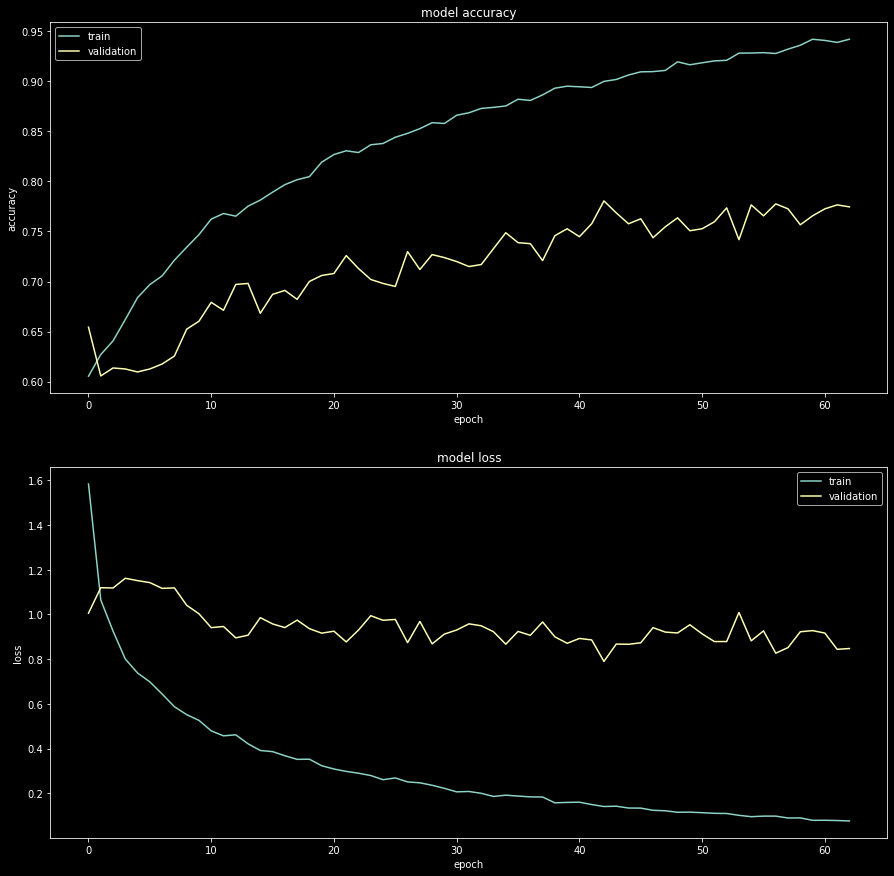

In [ ]:
plot_model_acc(history)

As we can see, the model overfits the training data heavily, but was still able to achieve ~78% accuracy on the validation set.

# For reference: How the model classified the data it trained on

Lets analyze how the model classified training data for reference before we analyze it's performance on the validation and test data.

Setting `shuffle = False` to get accurate prediction results

In [24]:
model_dir = os.path.join(os.getcwd(), 'drive', 'MyDrive', 'ham10k', "fine_tuned_.003_32.h5")
model = tf.keras.models.load_model(model_dir)

In [25]:
train_data.shuffle = False

In [36]:
y_pred = model.predict(train_data)

In [ ]:
model.evaluate(train_data)

266/266 [==============================] - 189s 712ms/step - loss: 0.2205 - accuracy: 0.9200


[0.22047312557697296, 0.9199953079223633]

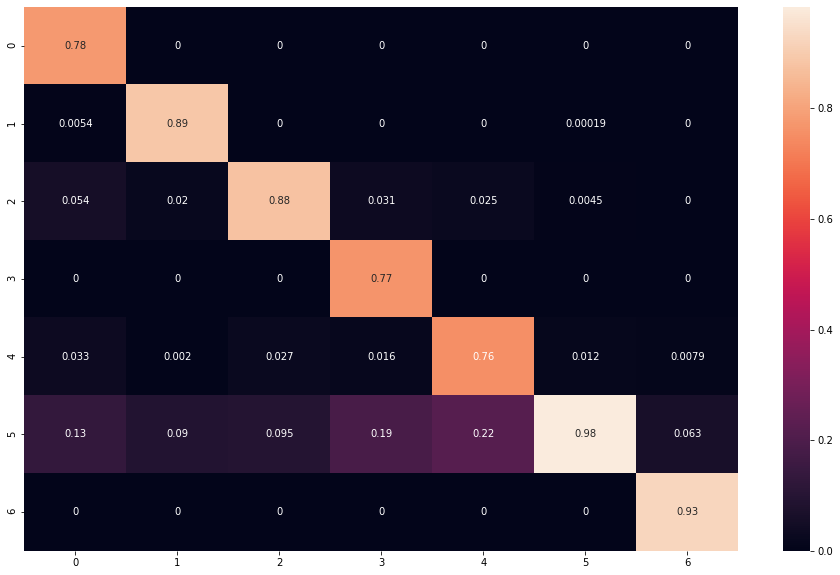

In [37]:
predicted_labels = np.argmax(y_pred, axis=1)

true_labels = train_data.classes
cm = confusion_matrix(true_labels, predicted_labels, normalize='pred') #normalized over predicted labels
plt.figure(figsize=(16,10))
f = sns.heatmap(cm, annot=True)

The confusion matrix is plotted with True labels as the rows, and Predicted labels as the columns. As expected, with an accuracy of 92%, the model has a high level of performance when classifying the training set. Below we can see what label corresponds with each index.

In [ ]:
list(train_data.class_indices)

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

In [31]:
print(classification_report(true_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.81      1.00      0.90       285
           1       0.88      0.99      0.94       438
           2       0.88      0.92      0.90       937
           3       0.79      1.00      0.88        98
           4       0.75      0.90      0.82       967
           5       0.99      0.92      0.95      5670
           6       0.93      1.00      0.96       117

    accuracy                           0.92      8512
   macro avg       0.86      0.96      0.91      8512
weighted avg       0.93      0.92      0.93      8512



# How the model performed on the validation set

Setting `shuffle = False`

In [32]:
val_data.shuffle = False

In [38]:
y_pred = model.predict(val_data)

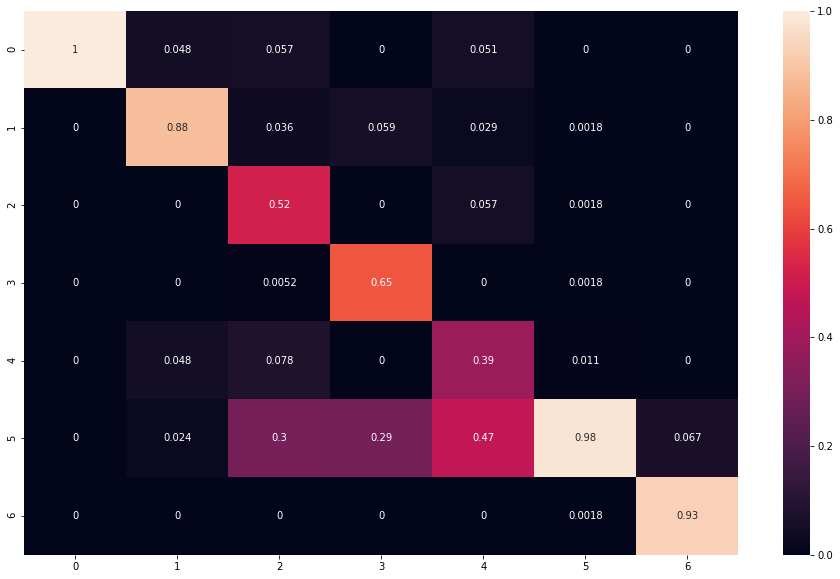

In [39]:
predicted_labels = np.argmax(y_pred, axis=1)

true_labels = val_data.classes   

cm = confusion_matrix(true_labels, predicted_labels, normalize='pred') #normalized over the predicted labels
plt.figure(figsize=(16,10))
f = sns.heatmap(cm, annot=True)

In [ ]:
print(classification_report(true_labels, predicted_labels))

              precision    recall  f1-score   support

           0       1.00      0.24      0.39        29
           1       0.88      0.73      0.80        51
           2       0.52      0.90      0.66       111
           3       0.65      0.85      0.73        13
           4       0.39      0.75      0.51        91
           5       0.98      0.79      0.87       697
           6       0.93      0.93      0.93        15

    accuracy                           0.78      1007
   macro avg       0.76      0.74      0.70      1007
weighted avg       0.87      0.78      0.80      1007



# Testing the model with the best validation performance on the Test set

In [40]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    # rescale = 1./255
    preprocessing_function = preprocess_input
)

test_data = test_datagen.flow_from_dataframe(
    test_df,
    x_col = 'image',
    y_col = 'dx',
    shuffle = False,
    seed =930,
    batch_size = BATCH_SIZE,
    class_mode = 'categorical'
)



Found 496 validated image filenames belonging to 7 classes.


In [41]:
test_loss, test_acc = model.evaluate(test_data)
print('test acc:', test_acc)

8/8 [==============================] - 7s 623ms/step - loss: 0.8789 - accuracy: 0.7339
test acc: 0.7338709831237793


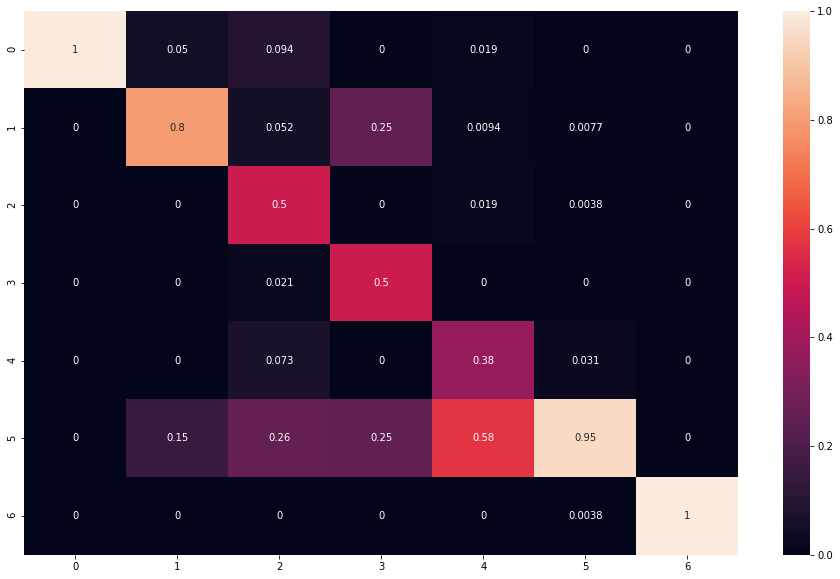

In [44]:
y_pred = model.predict(test_data)
predicted_labels = np.argmax(y_pred, axis=1)

true_labels = test_data.classes
cm = confusion_matrix( true_labels, predicted_labels, normalize='pred')
plt.figure(figsize=(16,10))
f = sns.heatmap(cm, annot=True)

In [ ]:
print(classification_report(true_labels, predicted_labels))

              precision    recall  f1-score   support

           0       1.00      0.08      0.14        13
           1       0.80      0.64      0.71        25
           2       0.50      0.94      0.65        51
           3       0.50      0.50      0.50         4
           4       0.38      0.73      0.50        55
           5       0.95      0.73      0.83       338
           6       1.00      0.90      0.95        10

    accuracy                           0.73       496
   macro avg       0.73      0.65      0.61       496
weighted avg       0.83      0.73      0.75       496



In [45]:
test_data.class_indices

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}